# Изучение закономерностей, определяющих успешность игр

### Цель проекта:

Исследовать параметры, влияющие на успешность игр, изучить все закономерности. Результаты исследования будут использованы для планирования рекламных кампаний в 2017 году.

### Изучение общей информации о данных

In [1]:
#импортируем все необходимые библиотеки
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np

In [2]:
#открываем файл и указываем разделитель
data = pd.read_csv('/datasets/games.csv', sep=',')

In [3]:
#выводим для проверки первые 5 строк
data.head(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


На первый взгляд, в данных много пропущенных значений в столбцах с рейтингами, и некорректные названия столбцов

In [4]:
#выведем общую информацию о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


В таблице 16715 строк, 11 столбцов. Столбец с годом выпуска игры имеет вещественный тип, нужно будет поменять на целый. В столбце с рейтингом пользователей нужно, на мой взгляд, поменять тип данных, согласно столбцу critic_score, множественные пропуски в столбцах с рейтингами подтверждаются, есть также небольшое количество пропусков в столбце с годом выпуска игры

In [5]:
#оценим первоначальное количество строк, чтобы после предобработки данных посчитать долю удаленных строк
data_old = data.shape[0]
print(data_old)

16715


### Предобработка данных 

#### Переименование столбцов

Приведем все столбцы к нижнему регистру:

In [6]:
data.columns = data.columns.str.lower()

In [7]:
#выводим для проверки первые 5 строк
data.head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


#### Обработка пропусков

Выведем общую информацию о пропусках

In [8]:
data.isnull().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

По 2 пропуска в столбце name и genre. Есть небольшое количество пропусков в year_of_release. А вот в рейтингах очень много пропусков. В том числе в рейтинге ESRB. 

In [9]:
data.isna().mean()

name               0.000120
platform           0.000000
year_of_release    0.016093
genre              0.000120
na_sales           0.000000
eu_sales           0.000000
jp_sales           0.000000
other_sales        0.000000
critic_score       0.513192
user_score         0.400897
rating             0.404786
dtype: float64

Пропусков в столбцах с рейтингами  - 51, 40, 40% от общего объема данных. Это очень высокая цифра, заполнение их средним, медианным значением даже с группировкой по жанру и платформе игры может сильно исказить общую картину, к тому же определить логику проставления рейтинга ESRB не представляется возможным.

Рейтинг ESRB - категориальная переменная, поэтому пропуски в данных (NaN) мы можем заполнить значением "Unknown", так мы не потеряем 40% данных при анализе.

In [10]:
data['rating'] = data['rating'].fillna('Unknown')

In [11]:
#проверяем результат:
data['rating'].unique()

array(['E', 'Unknown', 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'],
      dtype=object)

С рейтингом критиков и пользовательским рейтингом все немного сложнее. В них проставлены числовые значения, а значит, заполнение 0, например, пропусков сместит их средние значения. Поэтому оставим в них значения NaN.

Доля пропусков в столбце с годами выпуска составляет 1.6%, заполнить эти пропуски не представляется возможным, однако в исследовательском анализе данных этот столбец будет довольно активно задействован, а пропущенные значения будут искажать графики, поэтому считаю целесообразным их удалить.

In [12]:
#удаляем пропуски в столбце year_of_release
data = data.dropna(subset = ['year_of_release'])

In [13]:
#проверяем, что все ок
data['year_of_release'].isnull().sum()

0

Пропуски в имени игры и жанре также удалим, поскольку они единичны:

In [14]:
data = data.dropna(subset = ['name'])

In [15]:
data = data.dropna(subset = ['genre'])

In [16]:
#проверяем итоговую информацию по пропускам
data.isnull().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         6605
rating                0
dtype: int64

#### Изменение типов данных

In [17]:
#проверяем, что находится в столбце с годом выпуска перед изменением типа данных
data['year_of_release'].unique()

array([2006., 1985., 2008., 2009., 1996., 1989., 1984., 2005., 1999.,
       2007., 2010., 2013., 2004., 1990., 1988., 2002., 2001., 2011.,
       1998., 2015., 2012., 2014., 1992., 1997., 1993., 1994., 1982.,
       2016., 2003., 1986., 2000., 1995., 1991., 1981., 1987., 1980.,
       1983.])

Со значениями все в порядке, можно поменять тип:

In [18]:
#меняем тип на int:
data['year_of_release'] = data['year_of_release'].astype('int')

In [19]:
#проверяем, что все ок
data['year_of_release'].unique()

array([2006, 1985, 2008, 2009, 1996, 1989, 1984, 2005, 1999, 2007, 2010,
       2013, 2004, 1990, 1988, 2002, 2001, 2011, 1998, 2015, 2012, 2014,
       1992, 1997, 1993, 1994, 1982, 2016, 2003, 1986, 2000, 1995, 1991,
       1981, 1987, 1980, 1983])

In [20]:
#проверяем, что находится в столбце с рейтингом пользователей перед изменением типа данных
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Как и содержится в спецификации, в столбце находятся рейтинги от 0 до 10. Однако помимо NaN, есть значение "tbd" (= to be determined???). Опечаткой это быть не может. Скорее всего, строковое значение появилось в столбце в результате системной ошибки. Необходимо сообщить об этом и составить bug report

In [21]:
#проверим, какая доля таких значений по отношению к общему количеству данных:
print(len(data.query('user_score == "tbd"')) / len(data))

0.14449039163220628


Более 14%! Игнорировать или удалять такие значения точно нельзя. Заполнять значением 0 также некорректно, это может сильно исказить средние значения рейтингов. Логичнее всего расценивать это аномальное значение, как пропуск.

In [22]:
#посмотрим, что это за строки
data.query('user_score == "tbd"').head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
718,Just Dance Kids,Wii,2010,Misc,1.52,0.54,0.0,0.18,NaN,tbd,E


Все данные в столбцах различаются, какой-то закономерности появления аномального значения в пользовательском рейтинге нет, скорее всего, это техническая ошибка. Переведем аномальные значения к NaN и изменим тип данных в поле

In [23]:
#с помощью оператора to_numeric меняем тип, атрибут errors = 'coerce' принудительно проставит NaN в аномалиях
data['user_score'] = pd.to_numeric(data['user_score'], errors = 'coerce')

In [24]:
#проверяем, что аномалии больше нет
data['user_score'].unique()

array([8. , nan, 8.3, 8.5, 6.6, 8.4, 8.6, 7.7, 6.3, 7.4, 8.2, 9. , 7.9,
       8.1, 8.7, 7.1, 3.4, 5.3, 4.8, 3.2, 8.9, 6.4, 7.8, 7.5, 2.6, 7.2,
       9.2, 7. , 7.3, 4.3, 7.6, 5.7, 5. , 9.1, 6.5, 8.8, 6.9, 9.4, 6.8,
       6.1, 6.7, 5.4, 4. , 4.9, 4.5, 9.3, 6.2, 4.2, 6. , 3.7, 4.1, 5.8,
       5.6, 5.5, 4.4, 4.6, 5.9, 3.9, 3.1, 2.9, 5.2, 3.3, 4.7, 5.1, 3.5,
       2.5, 1.9, 3. , 2.7, 2.2, 2. , 9.5, 2.1, 3.6, 2.8, 1.8, 3.8, 0. ,
       1.6, 9.6, 2.4, 1.7, 1.1, 0.3, 1.5, 0.7, 1.2, 2.3, 0.5, 1.3, 0.2,
       0.6, 1.4, 0.9, 1. , 9.7])

In [25]:
#проверяем, что все типы данных корректные
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           16444 non-null  object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


#### Проверка аномалий и неявных дубликатов 

In [26]:
#посмотрим на значения в названиях игр
data['name'].unique()

array(['Wii Sports', 'Super Mario Bros.', 'Mario Kart Wii', ...,
       'Woody Woodpecker in Crazy Castle 5', 'LMA Manager 2007',
       'Haitaka no Psychedelica'], dtype=object)

Названий в столбце очень много, присутствуют символы как в верхнем, так и в нижнем регистре. А это говорит о том, что потенциально могут возникнуть неявные дубликаты. Проверить вручную этот объем не представляется возможным, поэтому чтобы избавиться от дубликатов, приведем все названия игр к верхнему регистру, после проверки остальных столбцов выполним удаление дубликатов, если они имеются

In [27]:
data['name'] = data['name'].str.upper()

In [28]:
#проверим значения в столбце с платформами
data['platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [29]:
#проверим значения в столбце с жанрами
data['genre'].unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy'], dtype=object)

In [30]:
#проверим, что в продажах нет отрицательных значений, выведем минимум и максимум по столбцу
print(data['na_sales'].min(), data['na_sales'].max())

0.0 41.36


In [31]:
#проверим, что в продажах нет отрицательных значений, выведем минимум и максимум по столбцу
print(data['eu_sales'].min(), data['eu_sales'].max())

0.0 28.96


In [32]:
#проверим, что в продажах нет отрицательных значений, выведем минимум и максимум по столбцу
print(data['jp_sales'].min(), data['jp_sales'].max())

0.0 10.22


In [33]:
#проверим, что в продажах нет отрицательных значений, выведем минимум и максимум по столбцу
print(data['other_sales'].min(), data['other_sales'].max())

0.0 10.57


In [34]:
#проверим значения в столбце с рейтингами критиков
data['critic_score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 41., 36., 31., 27., 35., 26., 19., 28., 23.,
       24., 21., 17., 13.])

In [35]:
#проверим значения в столбце с рейтингами ESRB
data['rating'].unique()

array(['E', 'Unknown', 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'],
      dtype=object)

Проверим, с какой частотой встречаются различные виды значений рейтинга ESRB:

In [36]:
data['rating'].value_counts()

Unknown    6676
E          3921
T          2905
M          1536
E10+       1393
EC            8
K-A           3
AO            1
RP            1
Name: rating, dtype: int64

Рейтинг RP, AO проставлен только у одной игры, K-A - у трех. Думаю, что это очень редкие рейтинги, доля их пренебрежимо мала в общем объеме данных, можно исключить их из анализа

In [37]:
data = data.loc[(data['rating'] != 'K-A') & (data['rating'] != 'AO') & (data['rating'] != 'RP')]

In [38]:
#смотрим, что получилось
data['rating'].unique()

array(['E', 'Unknown', 'M', 'T', 'E10+', 'EC'], dtype=object)

Теперь проверим на наличие дубликатов:

In [39]:
data.duplicated().sum() 

0

In [40]:
print(round((data_old - data.shape[0]) / data_old * 100, 2), '% строк удалено')

1.65 % строк удалено


 *Таким образом, в ходе предобработки данных были изменены типы и названия столбцов, обработаны аномалии в столбце с пользовательским рейтингом. Аномалий в данных больше не выявлено, дубликатов также нет. Удалено 1.65% строк.*

#### Подсчет общей суммы продаж по регионам 

In [41]:
#добавим столбец с общей суммой продаж:
data['total_sales'] = data[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)

#посмотрим, что получилось:
data.head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,WII SPORTS,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,SUPER MARIO BROS.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,Unknown,40.24
2,MARIO KART WII,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,WII SPORTS RESORT,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,POKEMON RED/POKEMON BLUE,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,Unknown,31.38


### Исследовательский анализ данных 

#### Выпуск игр по годам 

Посчитаем, какое количество игр выпускалось в каждом году:

In [42]:
#создаем сводную таблицу с группировкой по годам
data_year = data.pivot_table(index = 'year_of_release', values=['name'],aggfunc=['count'])
#для красоты меняем название столбца
data_year.columns = ['count']
#смотрим, что получилось
data_year

,count
year_of_release,
1980,9
1981,46
1982,36
1983,17
1984,14
1985,14
1986,21
1987,16
1988,15


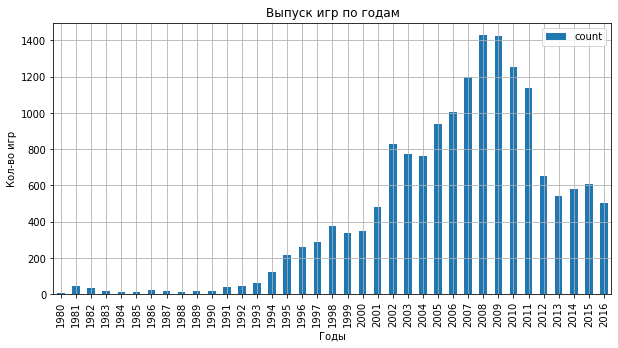

In [43]:
#а теперь построим столбчатую диаграмму для визуализации полученных результатов
(
    data_year
    .plot(y = 'count', 
          kind = 'bar', 
          grid = True, 
          figsize = (10, 5), 
          title = 'Выпуск игр по годам',
          xlabel = 'Годы',
          ylabel = 'Кол-во игр'
         )
);


Полученная гистограмма показывает, что до 1994 года игр выпускалось довольно мало. Рост этой индустрии начался с 1995 года, а в 2008-2009 годах было создано рекордное количество - около 1500 новых игр. Затем рост сменился падением. С 2012 по 2016 год ситуация в игровой индустрии стабилизировалась, динамические росты и падения сменились небольшими колебаниями около средней цифры в 500 игр. Таким образом, более информативный характер будут иметь данные о выпуске игр, начиная с 1994 года

#### Исследование продаж по платформам 

Изучим продажи по разным платформам. Для этого построим сводную таблицу, в которой будут суммироваться продажи игр с группировкой по платформам

In [44]:
#строим сводную таблицу, данные в столбцах с суммой продаж суммируем
data_platform = data.pivot_table(index = ['platform'], values=['total_sales'],aggfunc='sum')

#меняем название столбцов для красоты
data_platform.columns = ['total_sales']

#сортируем таблицу по значению общих продаж по всем регионам
data_platform = data_platform.sort_values(by = 'total_sales', ascending = False)
data_platform

,total_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78
PS,725.67
PS4,314.14
GBA,312.88
PSP,289.53


Выберем наиболее популярные платформы и построим их распределение по годам. Думаю, что логично выбрать топ-10 самых продаваемых платформ

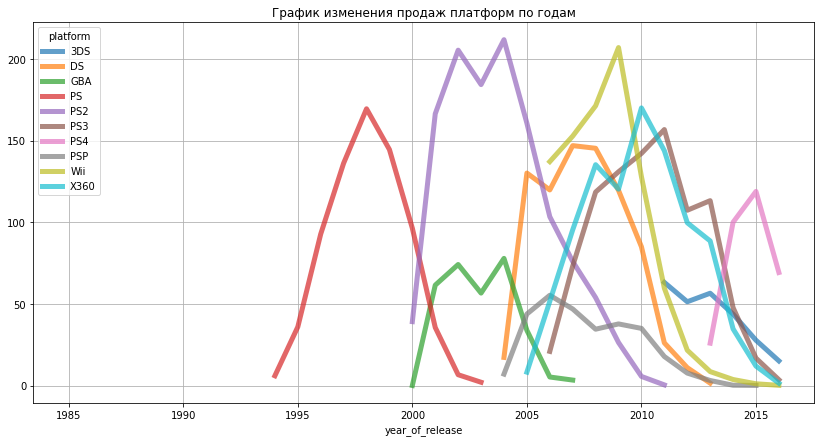

In [45]:
#запишем в переменную первые 10 платформ с самыми большими продажами
top10 = data_platform.head(10).index
#строим линейный график по каждой платформе
(data.query('platform in @top10')
    .pivot_table(index = 'year_of_release', columns = 'platform', values = 'total_sales', aggfunc = 'sum')
    .plot( 
            linewidth=5,
            alpha=0.7,
            grid=True,    
            legend=True,
            title='График изменения продаж платформ по годам',
            figsize = (14,7))
);


Полученные графики иллюстрируют, что платформы, как правило, популярны в среднем течении 5 лет, а затем спрос на них падает, и они исчезают. Поэтому для прогнозирования продаж на 2017 год подойдут данные за последние 4 года, данные за 2016 год сохраним.

#### Прогноз популярных платформ в 2017 году 

In [46]:
#выбираем данные по играм за последние 5 лет
data_actual = data.query('year_of_release >= 2014')


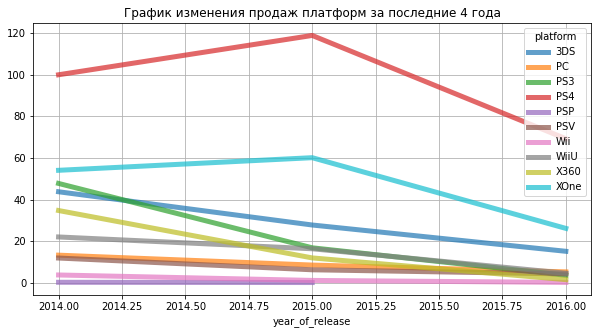

In [47]:
#cтроим линейный график по полученным результатам
(
    data_actual
        .pivot_table(index = 'year_of_release', columns = 'platform', values = 'total_sales', aggfunc = 'sum')
        .plot( 
            linewidth=5,
            alpha=0.7,
            grid=True,    
            legend=True,
            title='График изменения продаж платформ за последние 4 года',
            figsize = (10,5))
);

 По графику видно, что на 2016 год в фазе роста нет ни одной платформы. Лидером по продажам является PS4. В продажах платформ PSV, PC, PS3, X360, WiiU, Wii сильно стагнируют, продажи стремятся к нулю. Даже несмотря на то, что данные за 2016 год могут быть неполными, общий тренд графиков - спад. Из имеющихся платформ наиболее перспективными являются PS4, XOne и 3DS 

Построим "ящик с усами" по глобальным продажам игр в разбивке по платформам:

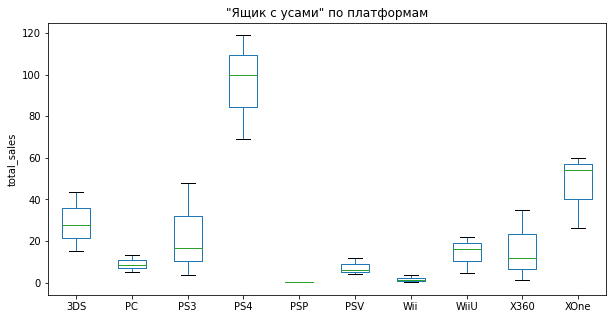

In [48]:
(data_actual
        .pivot_table(index = 'year_of_release', columns = 'platform', values = 'total_sales', aggfunc = 'sum')
        .plot( 
            kind = 'box',
            title='"Ящик с усами" по платформам',
            ylabel = 'total_sales',
            figsize = (10,5))
);


Из графика видно, что размах цифр глобальных продаж у разных платформ сильно отличается. У платформы PS4 и PS3 он самый большой, однако существуют платформы с очень узким размахом, например, Wii и PC. Медианное значение продаж, в основном, у платформ не смещено, находится на серединной позиции, за исключением WiiU, X360, Wii, PS3, у этих платформ оно сильно смещено. 

#### Влияние рейтингов критиков и пользователей на продажи по платформе 

Для изучения влияния отзывов пользователей и критиков на продажи возьмем данные о продажах самой популярной платформы. Лидером по продажам, как было выявлено ранее, является платформа PS2

In [49]:
#перечень нужных столбцов записываем в переменную
numeric_col = ['total_sales', 'critic_score', 'user_score']
#с помощью метода corr() находим коэффициент корреляции внутри платформы PS2
corr = data.loc[(data['platform'] == 'PS2'), numeric_col].corr()
#раскрашиваем ячейки для большей наглядности
corr.style.background_gradient(cmap='coolwarm')

,total_sales,critic_score,user_score
total_sales,1.000000,0.392536,0.175055
critic_score,0.392536,1.000000,0.565841
user_score,0.175055,0.565841,1.000000


Полученный коэффициент корреляции Пирсона между продажами и рейтингом критиков составляет 0.39. Это говорит о наличии умеренной положительной связи. То есть при повышении рейтинга в незначительной степени повышаются продажи игры. Вычисленный коэффициент корреляции для пользовательского рейтинга и продаж составляет 0.18, что свидетельствует о слабой связи, либо зависимость между этими величинами носит более сложный, нелинейный характер.

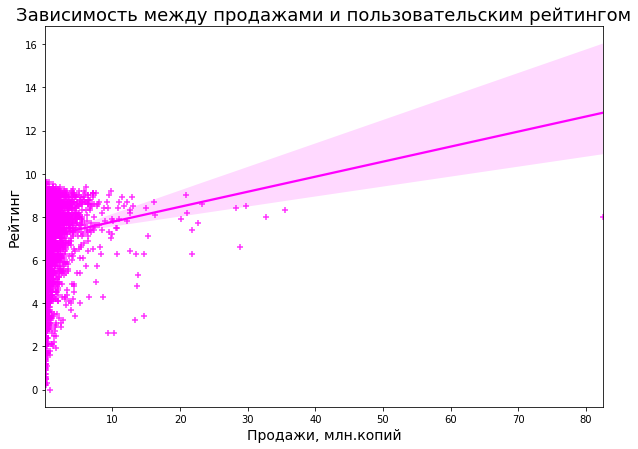

In [50]:
#строим диаграмму рассеяния с помощью библиотеки seaborn
fig = plt.figure(figsize=(10,7));
sb.regplot(x=data['total_sales'], y=data['user_score'],color='magenta', marker='+');


#Легенда, заголовок и подписи осей
plt.title('Зависимость между продажами и пользовательским рейтингом', size=18);
plt.xlabel('Продажи, млн.копий', size=14);
plt.ylabel('Рейтинг', size=14);

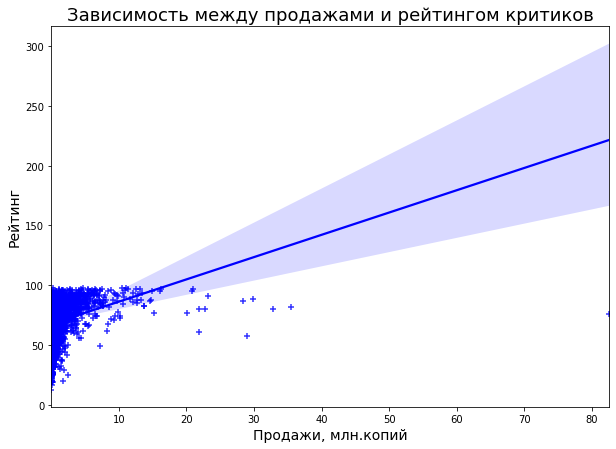

In [51]:
#строим диаграмму рассеяния с помощью библиотеки seaborn
fig = plt.figure(figsize=(10,7));
sb.regplot(x=data['total_sales'],y=data['critic_score'],color='blue', marker='+');


#Легенда, заголовок и подписи осей
plt.title('Зависимость между продажами и рейтингом критиков', size=18);
plt.xlabel('Продажи, млн.копий', size=14);
plt.ylabel('Рейтинг', size=14);

Получившееся облако не имеет наклона ни вверх, ни вниз, что как раз является показателем слабой связи. 

Попробуем посчитать коэффициент Пирсона для данных показателей в масштабах продаж по всем платформам:

In [52]:
#считаем коэффициент корреляции по всем строкам, для 3 столбцов
corr = data.loc[:, numeric_col].corr()
#раскрашиваем ячейки для большей наглядности
corr.style.background_gradient(cmap='coolwarm')

,total_sales,critic_score,user_score
total_sales,1.000000,0.245149,0.087789
critic_score,0.245149,1.000000,0.579655
user_score,0.087789,0.579655,1.000000


*Полученные коэффициенты корреляции еще более низкие в масштабе всех платформ. Таким образом, зависимость продаж от рейтинга критиков и пользователей не подтвеждается. Однако желательно провести повторный анализ на более репрезентативной выборке.*

#### Изучение зависимости между продажами и рейтингом ESRB 

Проведем анализ, существует ли какая-либо закономерность между значениями рейтинга ESRB и продажами игры. Поскольку это категориальная переменная, вычислить коэффициент корреляции не получится. Найдем суммарные продажи по каждому виду рейтинга:

In [53]:
data_rating = data.pivot_table(index = ['rating'], values=['total_sales'], aggfunc=['mean','sum'])
#меняем название столбцов для красоты
data_rating.columns = ['mean_sales', 'total_sales']
#записываем в переменную общую сумму продаж
total = data['total_sales'].sum()
#добавляем столбец с долей продаж
data_rating['share,%'] = round(data_rating['total_sales'] / total, 2) * 100

display(data_rating.sort_values(by = 'share,%', ascending = False))

,mean_sales,total_sales,"share,%"
rating,,,
Unknown,0.422723,2822.10,32.0
E,0.614030,2407.61,27.0
M,0.952168,1462.53,17.0
T,0.507084,1473.08,17.0
E10+,0.460144,640.98,7.0
EC,0.218750,1.75,0.0


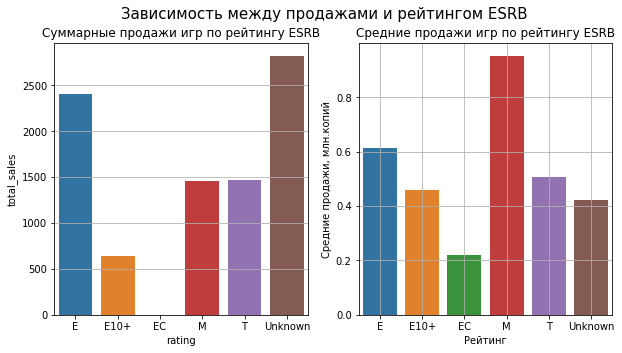

In [54]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,5));
fig.suptitle('Зависимость между продажами и рейтингом ESRB', fontsize=15);
                    
axes[0].set_title('Суммарные продажи игр по рейтингу ESRB');  
axes[0].set_xlabel('Рейтинг');
axes[0].set_ylabel('Суммарные продажи, млн.копий');
axes[0].grid(True);
sb.barplot(ax=axes[0], x=data_rating.index, y=data_rating['total_sales']);

sb.barplot(ax=axes[1], x=data_rating.index, y=data_rating['mean_sales']);
axes[1].set_title('Средние продажи игр по рейтингу ESRB');
axes[1].set_xlabel('Рейтинг');
axes[1].set_ylabel('Средние продажи, млн.копий');
axes[1].grid(True);


*В зависимости от того, по какой сумме продаж сравнивать рейтинги, мы получаем очень противоречивые данные. Если судить по суммарным продажам, то лидируют игры без указания рейтинга, затем рейтинг E, T и М. Но если посчитать средние продажи по рейтингу, то самый большой показатель здесь у рейтинга M, затем E и потом T. 
Значения рейтингов: Е - everyone (для всех), T - teenagers (подростки от 13 и выше), M - mature (от 17 и взрослее).*

#### Влияние жанров игр на продажи 

In [55]:
#строим сводную таблицу, данные в столбцах с суммой продаж суммируем
data_genre = data.pivot_table(index = ['genre'], values=['total_sales'], aggfunc=['mean', 'sum'])

#меняем название столбцов для красоты
data_genre.columns = ['mean_sales', 'total_sales']
#добавляем столбец с долей
data_genre['share,%'] = round(data_genre['total_sales'] / total, 2) * 100
#сортируем таблицу по значению средних продаж по всем регионам
data_genre = data_genre.sort_values(by = ['mean_sales'], ascending = False)
display(data_genre)

,mean_sales,total_sales,"share,%"
genre,,,
Platform,0.940262,825.55,9.0
Shooter,0.803519,1041.36,12.0
Role-Playing,0.628683,931.08,11.0
Racing,0.590122,723.49,8.0
Sports,0.567940,1309.67,15.0
Fighting,0.528865,442.66,5.0
Action,0.518621,1714.56,19.0
Misc,0.458360,788.38,9.0
Simulation,0.452695,387.96,4.0


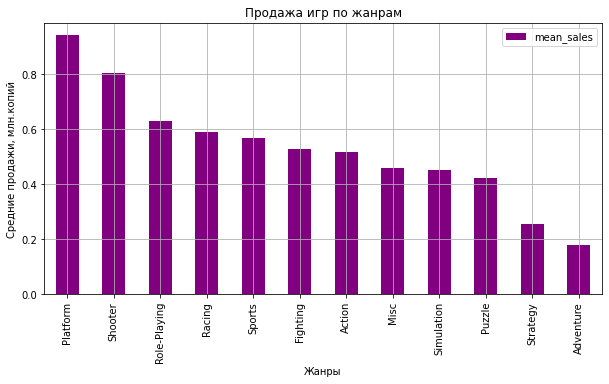

In [56]:
#построим столбчатую гистограмму, чтобы визуализировать полученный результат
(
    data_genre
    .plot(y = 'mean_sales', 
          kind = 'bar', 
          grid = True, 
          figsize = (10, 5), 
          title = 'Продажа игр по жанрам',
          xlabel = 'Жанры',
          ylabel = 'Средние продажи, млн.копий',
          color = 'purple'
         )
);


*Итак, если сравнить игровые жанры по средней выручке, то в ТОП-5 самых прибыльных вошли жанры Platform, Shooter, Role_playing, Racing, Sports. При этом стоит заметить, что у Platform, лидера по средним продажам, доля в общих продажах всего 9%, такая же невысокая доля у Racing - всего 8%. Жанр Action, не вошедший в пятерку по средним продажам, занимает самую высокую долю - 19% продаж*

### Портрет пользователя по каждому региону 

#### Топ-5 самых популярных платформ, жанров и рейтингов в регионах 

Определим, какие платформы самые популярные в Северной Америке (NA), Европе (EU) и Японии (JP)

In [57]:
#создадим функцию, которая на вход будет получать датафрейм и продажи по региону, 
#а на выходе возвращать сводную таблицу, отсортированную по убыванию значений
def region_portrait(rowdata, sales,  total, pivot_ind):
    data_portrait = rowdata.pivot_table(index = pivot_ind, values=sales, aggfunc=['sum', 'mean'])
    data_portrait.columns = ['total_sales', 'mean_sales']
    data_portrait['mean_sales'] = round(data_portrait['mean_sales'], 2)
    data_portrait['share_of_sales, %'] = round(data_portrait['total_sales'] / total, 2)
    data_portrait = data_portrait.sort_values(by = 'share_of_sales, %', ascending = False)

    return data_portrait.head(5)


In [58]:
#предварительно рассчитаем суммарные продажи по региону
total_sum = data['na_sales'].sum()
#вызываем функцию, указываем аргументы, выводим на экран
#результаты вызова функции записываем в переменные, они понадобятся для дальнейшей визуализации данных
print('ТОП-5 самых популярных платформ')
usa1 = region_portrait(rowdata = data, sales = 'na_sales', total = total_sum, pivot_ind = 'platform' )
display(usa1)

print('Распределение продаж по жанрам')
usa2 = region_portrait(rowdata = data, sales = 'na_sales', total = total_sum, pivot_ind = 'genre' )
display(usa2)

print('Распределение продаж по рейтингам')
usa3 = region_portrait(rowdata = data, sales = 'na_sales', total = total_sum, pivot_ind = 'rating' )
display(usa3)


ТОП-5 самых популярных платформ


,total_sales,mean_sales,"share_of_sales, %"
platform,,,
X360,595.74,0.48,0.14
PS2,572.92,0.27,0.13
Wii,486.87,0.38,0.11
DS,380.31,0.18,0.09
PS3,390.13,0.30,0.09


Распределение продаж по жанрам


,total_sales,mean_sales,"share_of_sales, %"
genre,,,
Action,861.91,0.26,0.20
Sports,671.20,0.29,0.15
Shooter,584.83,0.45,0.13
Platform,444.44,0.51,0.10
Misc,399.31,0.23,0.09


Распределение продаж по рейтингам


,total_sales,mean_sales,"share_of_sales, %"
rating,,,
E,1274.24,0.32,0.29
Unknown,1225.84,0.18,0.28
M,742.89,0.48,0.17
T,747.60,0.26,0.17
E10+,345.50,0.25,0.08


Таким образом, самыми популярными платформами (в учете по доле в общих продажах по региону) в Северной Америке являются X360, PS2, Wii, DS, PS3. В анализ также добавлено значение средней выручки по платформе, которое иллюстрирует, что у самой популярной платформы может быть не самая большая средняя выручка, например, средняя выручка по платформе Wii выше, чем у лидера X360. 
Пользователи отдают предпочтение играм жанра Action, Sports, Shooter, Platform, Misc. Здесь также наблюдается тенденция, что средняя выручка у игр не на первой позиции по доле в продажах выше. 

Распределение продаж по рейтингу ESRB в данном регионе: Е, игры без рейтинга, M, T, Е10+

Повторяем предыдущие операции для региона - Европа

In [59]:
#предварительно рассчитаем суммарные продажи по региону
total_sum = data['eu_sales'].sum()
#вызываем функцию, указываем аргументы, выводим на экран
print('ТОП-5 самых популярных платформ')
eu1 = region_portrait(rowdata = data, sales = 'eu_sales', total = total_sum, pivot_ind = 'platform')
display(eu1)

print('Распределение продаж по жанрам')
eu2 = region_portrait(rowdata = data, sales = 'eu_sales', total = total_sum, pivot_ind = 'genre' )
display(eu2)

print('Распределение продаж по рейтингам')
eu3 = region_portrait(rowdata = data, sales = 'eu_sales', total = total_sum, pivot_ind = 'rating' )
display(eu3)


ТОП-5 самых популярных платформ


,total_sales,mean_sales,"share_of_sales, %"
platform,,,
PS3,327.21,0.25,0.14
PS2,332.63,0.16,0.14
X360,268.32,0.22,0.11
Wii,258.32,0.20,0.11
PS,212.23,0.18,0.09


Распределение продаж по жанрам


,total_sales,mean_sales,"share_of_sales, %"
genre,,,
Action,510.38,0.15,0.21
Sports,371.33,0.16,0.15
Shooter,314.52,0.24,0.13
Racing,234.49,0.19,0.10
Misc,210.44,0.12,0.09


Распределение продаж по рейтингам


,total_sales,mean_sales,"share_of_sales, %"
rating,,,
E,703.87,0.18,0.29
Unknown,609.65,0.09,0.25
M,480.00,0.31,0.20
T,421.79,0.15,0.18
E10+,183.35,0.13,0.08


Cамыми популярными платформами в Европе являются PS3, PS2, X360, Wii, PS. Пользователи отдают предпочтение играм жанра Action, Sports, Shooter, Racing, Misc. Распределение продаж по рейтингу ESRB в данном регионе: лидируют E, игры без рейтинга, M, T, Е10+. В целом, можно сказать, что игровые предпочтения в регионах Северная Америка и Европа довольно схожие.

Рассмотрим основные пользовательские характеристики для региона Япония

In [60]:
#предварительно рассчитаем суммарные продажи по региону
total_sum = data['jp_sales'].sum()
#вызываем функцию, указываем аргументы, выводим на экран
print('ТОП-5 самых популярных платформ')
jp1 = region_portrait(rowdata = data, sales = 'jp_sales', total = total_sum, pivot_ind = 'platform')
display(jp1)

print('Распределение продаж по жанрам')
jp2 = region_portrait(rowdata = data, sales = 'jp_sales', total = total_sum, pivot_ind = 'genre')
display(jp2)

print('Распределение продаж по рейтингам')
jp3 = region_portrait(rowdata = data, sales = 'jp_sales', total = total_sum, pivot_ind = 'rating')
display(jp3)

ТОП-5 самых популярных платформ


,total_sales,mean_sales,"share_of_sales, %"
platform,,,
DS,175.02,0.08,0.14
PS,138.32,0.12,0.11
PS2,137.54,0.06,0.11
SNES,116.55,0.49,0.09
NES,98.65,1.01,0.08


Распределение продаж по жанрам


,total_sales,mean_sales,"share_of_sales, %"
genre,,,
Role-Playing,353.39,0.24,0.27
Action,160.14,0.05,0.12
Platform,130.71,0.15,0.10
Sports,134.93,0.06,0.10
Misc,105.56,0.06,0.08


Распределение продаж по рейтингам


,total_sales,mean_sales,"share_of_sales, %"
rating,,,
Unknown,836.74,0.13,0.65
E,197.96,0.05,0.15
T,150.70,0.05,0.12
M,63.58,0.04,0.05
E10+,40.20,0.03,0.03


Итак, в Японии лидирующие доли по продажам занимают платформы DS, PS, PS2, SNES, NES, что очень сильно отличает этот регион от Северной Америки и Европы. По жанрам лидирующие позиции (доля в общих продажах по региону): Role-playing, Action, Platform, Sports, Misc. Здесь только есть отличия от других регионов. А вот распределение по рейтингам довольно схожее: игры без рейтинга, затем E, T, M

#### Визуализация портрета пользователя по регионам 

Для большей наглядности визуализируем все полученные портреты.

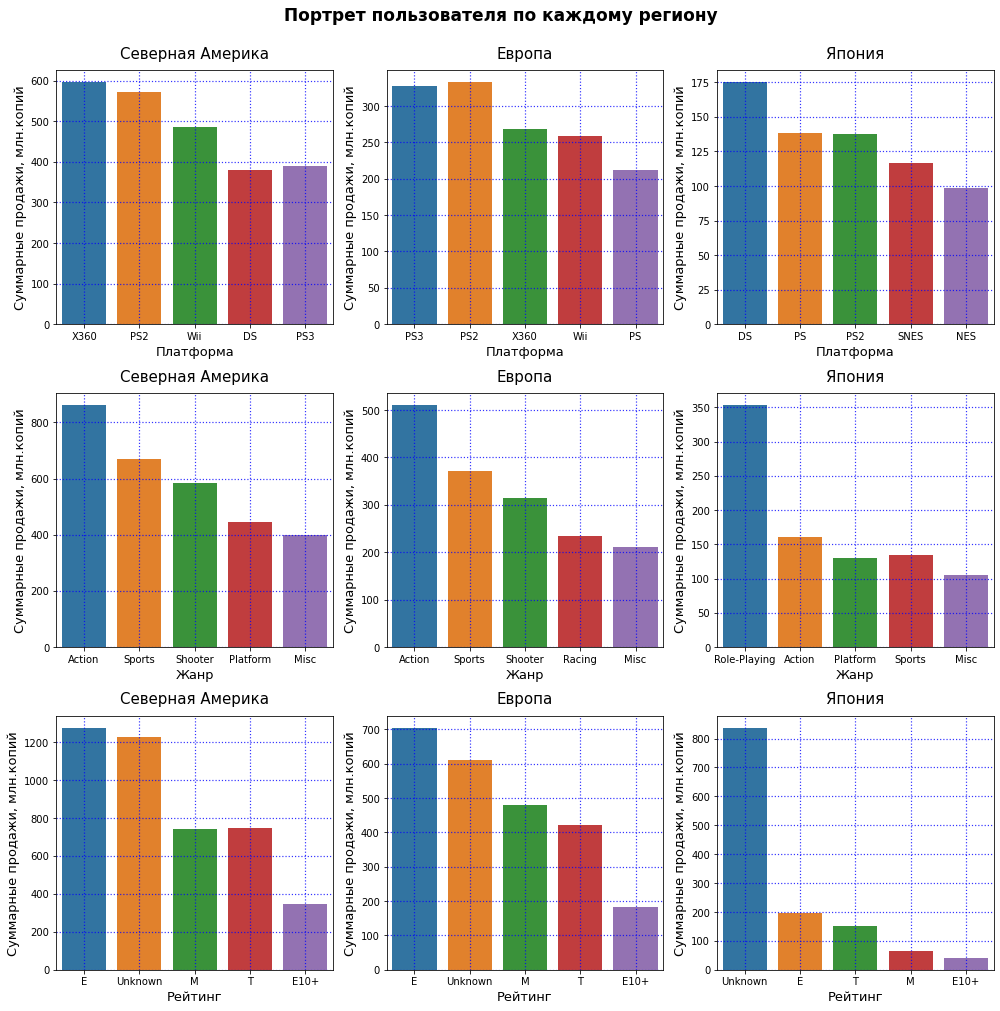

In [61]:
plt.figure(figsize=[14, 14])
plt.suptitle('Портрет пользователя по каждому региону', y=1.00, fontsize=17, fontweight='bold') 
#График 1
plt.subplot(3, 3, 1)
sb.barplot(x=usa1.index, y=usa1['total_sales']);
plt.title('Северная Америка', fontsize=15, pad=12)
plt.xlabel('Платформа', fontsize=13)
plt.ylabel('Суммарные продажи, млн.копий', fontsize=13)
plt.grid(alpha=0.8, color='blue', linestyle=':', linewidth=1.2)

#График 2
plt.subplot(3, 3, 2)

sb.barplot(x=eu1.index, y=eu1['total_sales']);
plt.title('Европа', fontsize=15, pad=12)
plt.xlabel('Платформа', fontsize=13)
plt.ylabel('Суммарные продажи, млн.копий', fontsize=13)
plt.grid(alpha=0.8, color='blue', linestyle=':', linewidth=1.2)

#График 3
plt.subplot(3, 3, 3)

sb.barplot(x=jp1.index, y=jp1['total_sales']);
plt.title('Япония', fontsize=15, pad=12)
plt.xlabel('Платформа', fontsize=13)
plt.ylabel('Суммарные продажи, млн.копий', fontsize=13)
plt.grid(alpha=0.8, color='blue', linestyle=':', linewidth=1.2)

#График 4
plt.subplot(3, 3, 4)
sb.barplot(x=usa2.index, y=usa2['total_sales']);
plt.title('Северная Америка', fontsize=15, pad=12)
plt.xlabel('Жанр', fontsize=13)
plt.ylabel('Суммарные продажи, млн.копий', fontsize=13)
plt.grid(alpha=0.8, color='blue', linestyle=':', linewidth=1.2)

#График 5
plt.subplot(3, 3, 5)

sb.barplot(x=eu2.index, y=eu2['total_sales']);
plt.title('Европа', fontsize=15, pad=12)
plt.xlabel('Жанр', fontsize=13)
plt.ylabel('Суммарные продажи, млн.копий', fontsize=13)
plt.grid(alpha=0.8, color='blue', linestyle=':', linewidth=1.2)

#График 6
plt.subplot(3, 3, 6)

sb.barplot(x=jp2.index, y=jp2['total_sales']);
plt.title('Япония', fontsize=15, pad=12)
plt.xlabel('Жанр', fontsize=13)
plt.ylabel('Суммарные продажи, млн.копий', fontsize=13)
plt.grid(alpha=0.8, color='blue', linestyle=':', linewidth=1.2)

#График 7
plt.subplot(3, 3, 7)
sb.barplot(x=usa3.index, y=usa3['total_sales']);
plt.title('Северная Америка', fontsize=15, pad=12)
plt.xlabel('Рейтинг', fontsize=13)
plt.ylabel('Суммарные продажи, млн.копий', fontsize=13)
plt.grid(alpha=0.8, color='blue', linestyle=':', linewidth=1.2)

#График 8
plt.subplot(3, 3, 8)

sb.barplot(x=eu3.index, y=eu3['total_sales']);
plt.title('Европа', fontsize=15, pad=12)
plt.xlabel('Рейтинг', fontsize=13)
plt.ylabel('Суммарные продажи, млн.копий', fontsize=13)
plt.grid(alpha=0.8, color='blue', linestyle=':', linewidth=1.2)

#График 9
plt.subplot(3, 3, 9)

sb.barplot(x=jp3.index, y=jp3['total_sales']);
plt.title('Япония', fontsize=15, pad=12)
plt.xlabel('Рейтинг', fontsize=13)
plt.ylabel('Суммарные продажи, млн.копий', fontsize=13)
plt.grid(alpha=0.8, color='blue', linestyle=':', linewidth=1.2)

plt.tight_layout()
plt.show()

Визуализация данных о региональных предпочтениях в части платформ показывает, что в Северной Америке и Европе практически идентичный набор платформ, различия только в долях этих платформ по общим продажам региона. В Японии пятерка самых популярных платформ совсем другая.

Жанровые предпочтения: Северная Америка и Европа имеют практически одинаковые предпочтения по жанрам, даже их доли в общих продажах по региону довольно близки. А в Японии лидирующую позицию занимает жанр Role-playing, которого нет в топ-5 в Северной Америке и Европе. Причем доля этого жанра в Японии очень высокая по сравнению с остальными. 

Если рассмотреть распределение продаж игр в разрезе рейтинга ESRB, то у Северной Америки и Европы снова весьма схожие результаты, одна и та же последовательность лидеров, с небольшими отличиями по долям в общих продажах по региону. В Японии у игр без рейтинга самая высокая доля в продажах, все остальные рейтинги заметно уступают в долях. 
Полученные визуальные результаты портретов пользователей вполне объясняют, почему страна Япония была выделена в отдельный регион.

### Проверка гипотез 

#### Средние пользовательские рейтинги платформ XOne и PC одинаковые 

H_0: Пользовательский рейтинг (user_score) платформы XOne = пользовательский рейтинг (user_score) платформы PC
H_a: Пользовательский рейтинг (user_score) платформы XOne ≠ пользовательский рейтинг (user_score) платформы PC

Установим пороговое значение alpha = 0.05

В столбце с пользовательским рейтингом почти половина пропусков, этого статистические методы не любят, поэтому предварительно удалим пропуски:

In [62]:
#удаляем пропуски в столбце user_score
data = data.dropna(subset = ['user_score'])

In [63]:
#проверяем, что пропусков нет
data['user_score'].isnull().sum()

0

In [64]:
user_score_xone = data.loc[data['platform'] == 'XOne', 'user_score']
user_score_pc = data.loc[data['platform'] == 'PC', 'user_score']
# results = вызов метода для проверки гипотезы
#equal_var устанавливаем в False, поскольку нет уверенности о равенстве дисперсий этих выборок
alpha = .05
results = st.ttest_ind(
    user_score_xone, 
    user_score_pc,
    equal_var = False)
# вывод значения p-value на экран 
print('Среднее значение по платформе XOne:', round(user_score_xone.mean(), 2))
print('Среднее значение по платформе PC:', round(user_score_pc.mean(),2))
print(results.pvalue)
# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Среднее значение по платформе XOne: 6.52
Среднее значение по платформе PC: 7.06
5.2790724212074864e-06
Отвергаем нулевую гипотезу


*По результатам теста нулевую гипотезу нужно отвергнуть, в расчет следует принять альтернативную гипотезу о том, что средний пользовательский рейтинг платформы XOne не совпадает со средним пользовательским рейтингом платформы PC
Выведенные средние значения по платформам еще раз подтверждают верность результата статистического теста*

#### Средние пользовательские рейтинги жанра Action и Sports разные 

H_0: Пользовательский рейтинг (user_score) жанра Action = пользовательский рейтинг (user_score) жанра Sports
H_1: Пользовательский рейтинг (user_score) жанра Action ≠ пользовательский рейтинг (user_score) жанра Sports

Установим пороговое значение alpha = 0.05

In [65]:
user_score_action = data.loc[data['genre'] == 'Action', 'user_score']
user_score_sports = data.loc[data['genre'] == 'Sports', 'user_score']
# results = вызов метода для проверки гипотезы
#equal_var устанавливаем в False, поскольку нет уверенности о равенстве дисперсий этих выборок
alpha = .05
results = st.ttest_ind(
    user_score_action, 
    user_score_sports,
    equal_var = False)
# вывод значения p-value на экран 
print('Среднее значение по жанру Action:', round(user_score_action.mean(), 2))
print('Среднее значение по жанру Sports:', round(user_score_sports.mean(),2))
print(results.pvalue)
# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Среднее значение по жанру Action: 7.06
Среднее значение по жанру Sports: 6.95
0.07607291840585198
Не получилось отвергнуть нулевую гипотезу


*По результатам теста не получилось отвергнуть нулевую гипотезу о том, что средний пользовательский рейтинг жанра Action совпадает со средним пользовательским рейтингом жанра Sports.*

*Выведенное среднее значение рейтингов по этим жанрам дополнительно подтверждает корректность результата статистического теста*

### Общий вывод 

<div class="alert alert-info"> <b>
На основе данных по статистике продаж игр был проведен анализ зависимости разных параметров на их популярность (= продаваемость). Результаты исследования будут учтены при построении маркетингового прогноза на 2017 год. </b> 
    
<b>        На этапе предобработки данных в исходном датафрейме были изменены типы данных в столбцах, удалены немногочисленные пропуски. В целом данные довольно качественные, дубликатов нет, аномальных значений в большинстве столбцов нет, однако в столбцах с информацией о рейтингах (пользовательский, рейтинг критиков и ESRB) от 40 до 50% составляют пропуски. Также была выявлена аномалия в значениях пользовательского рейтинга. Редкие значения рейтингов ESRB (единичная частота в данных) были исключены из анализа, а пропущенные значения заменены значением "Unknown", чтобы не потерять эту долю при исследовательском анализе. Из-за большой доли пропусков исходный датасет в части данных о рейтингах критиков и пользовательском рейтинге сложно назвать репрезентативным. 
   
<b>    Перед исследованием были выдвинуты следующие гипотезы: </b>
    
<b>     Гипотеза 1. Выпуск игр меняется от года к году</b>
    
<b>     Гипотеза 2. На продажи игры влияет платформа, которую она поддерживает</b>
    
<b>     Гипотеза 3. Продажи игры зависят от рейтингов пользователей и критиков</b>
    
<b>     Гипотеза 4. Жанр игры влияет на ее популярность</b>
    
<b>     Гипотеза 5. Портрет пользователей в регионах NA, EU, JP различается</b>
    
<b>     Гипотеза 6. Средние пользовательские рейтинги платформ XOne и PC одинаковые</b>
    
<b>      Гипотеза 7. Средние пользовательские рейтинги жанров Action и Sports разные</b>
    
<b>    В ходе анализа был изучен каждый из вышеперечисленных параметров, построены столбчатые диаграммы распределения значений, найдены коэффициенты корреляции с продажами, построены диаграммы рассеяния. В результате выявлены следующие зависимости:</b>
    
<b>     Гипотеза 1: подтверждена, рост выпуска игр начался в 1995 году, в 2008-2009 годах выпущено рекордное количество игр, а в последующие годы на рынке наметился спад. С 2012 по 2016 год выпуск игр более-менее стабилизировался - цифры находятся на среднем уровне, без сильных падений и взлетов.</b> 
    
<b>    Гипотеза 2: подтверждена, "средний срок жизни" платформы - около 5 лет, затем продажи на ней падают, и она исчезает. По состоянию продаж на 2016 год нет ни одной платформы, которая бы находилась в фазе роста. Наиболее перспективными являются платформы PS4, XOne и 3DS</b>
    
<b>    Гипотеза 3: не подтверждена, вычисленный коэффициент корреляции Пирсона показал наличие слабой связи между рейтингом критиков и продажами, и полное отсутствие зависимости между рейтингом пользователей и продажами игры. Однако желательно повторить этот анализ на более репрезентативной выборке</b>
    
<b>    Гипотеза 4. подтверждена. Наиболее прибыльными (с учетом анализа средней выручки) являются жанры Platform, Shooter, Role-Playing, Racing, Sports. При этом лидирующие позиции по средней выручке не совпадают с долями в общих продажах. Например, жанр Action, не вошедший в топ-5 по средней выручке, имеет самую большую долю в продажах. Наименее прибыльными являются жанры Strategy и Adventure, у них также маленькие доли в общих продажах</b>
    
<b>    Гипотеза 5: частично подтверждена. Полученные портреты пользователей для региона Северная Америка и Европа имеют практически одинаковые предпочтения по платформам, жанрам, рейтингам ESRB, имеются лишь небольшие отличия в долях от общих продаж по региону. А регион Япония заметно выделяется на их фоне, здесь популярны другие платформы и жанры. Распределение продаж по рейтингам ESRB также отличает Японию, лидирующую позицию здесь занимают игры без рейтинга. 
Полученные визуальные результаты портретов пользователей вполне объясняют, почему страна Япония была выделена в отдельный регион.</b>
       
<b>    Гипотеза 6: не подтверждена. По результатам проведенного статистического теста гипотезу пришлось отвергнуть и принять на рассмотрение альтернативную гипотезу: средние пользовательские рейтинги платформ XOne и PC отличаются. Однако желательно провести дополнительный анализ для подтверждения гипотезы на более репрезентативной выборке данных (в исходном наборе данных 40% пропусков в поле пользовательского рейтинга)</b>
    
<b>    Гипотеза 7: не подтверждена. По результатам статистического теста нулевую гипотезу о равенстве средних пользовательских рейтингов жанров Action и Sports отвергнуть не удалось. Однако желательно провести дополнительный анализ для подтверждения гипотезы на более репрезентативной выборке данных (в исходном наборе данных 40% пропусков в поле пользовательского рейтинга)</b>
    
<b>    Bug report: В ходе предобработки данных выявлены аномальные значения в столбце user_score = 'tbd' (более 14% от общего объема данных).</b>   
</div>    